In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from nltk.tokenize import TweetTokenizer
from nltk import FreqDist
from keras.preprocessing.text import Tokenizer
from sklearn import feature_extraction
import os
print(os.listdir("../input"))
import keras


# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.tsv', 'test.tsv', 'sampleSubmission.csv']


In [2]:
train=pd.read_csv("../input/train.tsv",sep="\t")
test=pd.read_csv("../input/test.tsv",sep="\t")
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [3]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()


In [4]:
def lemmize(column):
    leem=[]
    for sentence in column:
        lassos= [lemma.lemmatize(word) for word in word_tokenize(sentence)]
        lassos=' '.join(lassos)
        leem.append(lassos)
    return leem



In [5]:
train['clean_review']=lemmize(train["Phrase"])
train.head(10)

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,A series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,A series of escapade demonstrating the adage t...
2,3,1,A series,2,A series
3,4,1,A,2,A
4,5,1,series,2,series
5,6,1,of escapades demonstrating the adage that what...,2,of escapade demonstrating the adage that what ...
6,7,1,of,2,of
7,8,1,escapades demonstrating the adage that what is...,2,escapade demonstrating the adage that what is ...
8,9,1,escapades,2,escapade
9,10,1,demonstrating the adage that what is good for ...,2,demonstrating the adage that what is good for ...


In [6]:
X=train.clean_review.values
y=train.Sentiment.values
y=keras.utils.to_categorical(y,num_classes=5)
from sklearn.model_selection import train_test_split
(X_train,X_val,y_train,y_val)=train_test_split(X,y,test_size=0.3,random_state=50)

In [7]:
def distinct_words(X):
    totsent=""
    for sentence in X:
        totsent+=sentence
    alword=word_tokenize(totsent)
    return len(FreqDist(alword)) 

In [8]:
def MAX_LENGTH(X):
    for sent in X:
      r_len=[]
      gre=word_tokenize(sent)
      r_len.append(len(gre))
    max_sent=(np.max(r_len))
    return max_sent

In [9]:
dXt=distinct_words(X_train)
dXval=distinct_words(X_val)


In [10]:
dXt

86865

In [11]:
tokenize=Tokenizer(num_words=distinct_words(X_train))
tokenize.fit_on_texts(list(X_train))
X_train=tokenize.texts_to_sequences(X_train)
X_val=tokenize.texts_to_sequences(X_val)


In [12]:
from keras.preprocessing import sequence,text
X_train=sequence.pad_sequences(X_train,maxlen=53)
X_val=sequence.pad_sequences(X_val,maxlen=53)
X_train

array([[    0,     0,     0, ...,     5,  1144,    59],
       [    0,     0,     0, ...,     0,     0,  4489],
       [    0,     0,     0, ...,    74,  1259,   163],
       ...,
       [    0,     0,     0, ...,    91, 11911,    62],
       [    0,     0,     0, ...,   109, 11886,    89],
       [    0,     0,     0, ...,     4, 10689,   275]], dtype=int32)

In [13]:
from keras.models import Sequential
from keras.layers import LSTM,Embedding,Dense
from keras.optimizers import Adam
model1=Sequential()
model1.add(Embedding(dXt,100,mask_zero=True))
model1.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model1.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model1.add(Dense(5,activation='softmax'))
model1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         8686500   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 8,741,321
Trainable params: 8,741,321
Non-trainable params: 0
_________________________________________________________________


In [14]:
history1=model1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=5, batch_size=128, verbose=1)

Train on 109242 samples, validate on 46818 samples
Epoch 1/5
109242/109242 [==============================] - 300s 3ms/step - loss: 1.1309 - acc: 0.5572 - val_loss: 0.9089 - val_acc: 0.6341
Epoch 2/5
109242/109242 [==============================] - 297s 3ms/step - loss: 0.8470 - acc: 0.6539 - val_loss: 0.8563 - val_acc: 0.6499
Epoch 3/5
109242/109242 [==============================] - 297s 3ms/step - loss: 0.7763 - acc: 0.6793 - val_loss: 0.8459 - val_acc: 0.6561
Epoch 4/5
109242/109242 [==============================] - 293s 3ms/step - loss: 0.7366 - acc: 0.6961 - val_loss: 0.8468 - val_acc: 0.6551
Epoch 5/5
109242/109242 [==============================] - 296s 3ms/step - loss: 0.7057 - acc: 0.7077 - val_loss: 0.8490 - val_acc: 0.6582


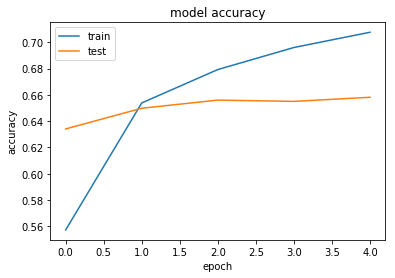

In [16]:
import matplotlib.pyplot as plt 
def plot(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot(history1)

In [17]:
X_test=pd.read_csv("../input/test.tsv",sep='\t')
X_test['clean_review']=lemmize(X_test["Phrase"])
X_test.head(10)

,PhraseId,SentenceId,Phrase,clean_review
0,156061,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...,An intermittently pleasing but mostly routine ...
2,156063,8545,An,An
3,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing but mostly routine
5,156066,8545,intermittently pleasing but,intermittently pleasing but
6,156067,8545,intermittently pleasing,intermittently pleasing
7,156068,8545,intermittently,intermittently
8,156069,8545,pleasing,pleasing
9,156070,8545,but,but


In [18]:
X_t=X_test['clean_review']
dt=distinct_words(X_t)
print

<function print>

In [ ]:
X_t

In [19]:
X_t=tokenize.texts_to_sequences(X_t)
X_t=sequence.pad_sequences(X_t,maxlen=53)
X_t

array([[   0,    0,    0, ...,  623,  909,  310],
       [   0,    0,    0, ...,  623,  909,  310],
       [   0,    0,    0, ...,    0,    0,   15],
       ...,
       [   0,    0,    0, ...,    2,  131, 7235],
       [   0,    0,    0, ...,    2,  131, 7235],
       [   0,    0,    0, ...,    0,  370, 1667]], dtype=int32)

In [20]:
prediction=model1.predict_classes(X_t,verbose=1)

66292/66292 [==============================] - 164s 2ms/step


In [21]:
sub=pd.read_csv('../input/sampleSubmission.csv')
sub.Sentiment=prediction
sub

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,3
6,156067,3
7,156068,2
8,156069,3
9,156070,2


In [ ]:
sub.to_csv('lu.csv',index=False)
sub.head(5)